In [1]:
%cd /home/aditya/Documents/SolarCycleProject/code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import gaussian
import src.preprocesser as pre
import src.network as network
import src.plotter as plotter 
from src.hyperparams import *

# import tf.keras
%load_ext autoreload
%matplotlib inline
%load_ext tensorboard

/home/aditya/Documents/SolarCycleProject/code


In [13]:
%autoreload

In [3]:
# Getting the data
headers = ["Year",
           "Month",
           "Day",
           "Decimal Date",
           "Daily Total Sunspot Number",
           "Sunspot Number Stddev",
           "No of observations",
           "Definitive/Provisional"
]
filename = "data/SN_d_tot_V2.0.csv"
data = pd.read_csv(filename, delimiter=";", names=headers)[:1000]

In [4]:
data

,Year,Month,Day,Decimal Date,Daily Total Sunspot Number,Sunspot Number Stddev,No of observations,Definitive/Provisional
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
995,1820,9,22,1820.725,-1,-1.0,0,1
996,1820,9,23,1820.728,25,6.3,1,1
997,1820,9,24,1820.731,-1,-1.0,0,1
998,1820,9,25,1820.734,0,2.0,1,1


In [5]:
# Data Preprocessing
dates, spots, inverter = pre.preprocess(data)

ymax: 202.0 ymin: 0.0
x.shape: (993,)
y.shape: (993,)


In [6]:
if mean_type == "gaussian":
    weights = gaussian(M=mean_length, std=0.1, sym=True)
    weights /= np.sum(weights) # normalise the weights
    spots = pre.running_mean_helper(spots, weights)
elif mean_type == "uniform":
    weights = np.ones(mean_length)/mean_length
    spots = pre.running_mean_helper(spots, weights)
else:
    pass


In [7]:
X = np.diff(spots)
index = dates[1:]
x_slid, y_slid, idx_slid = pre.sliding_window_main(X, X, index=index, predict_ahead=predict_ahead)
x_train, y_train, idx_train, x_val, y_val, idx_val, x_test, y_test, idx_test = pre.data_splitting_main(x_slid, y_slid, idx_slid)

x_slid.shape: (982, 10, 1)
y_slid.shape: (982, 1)
x_train.shape:  (576, 10, 1)
y_train.shape:  (576, 1)
idx_train.shape:  (576,)
x_val.shape:  (192, 10, 1)
y_val.shape:  (192, 1)
idx_val.shape:  (192,)
x_test.shape:  (192, 10, 1)
y_test.shape:  (192, 1)
idx_test.shape:  (192,)



In [8]:
net = network.create_network()

In [9]:
history = network.trainer(net, x_train, y_train, x_val, y_val, verbose=2)
var_train = np.var(y_train)
var_val = np.var(y_val)
print("Variance in y_train:", var_train)
print("Variance in y_val:", var_val)

Train on 576 samples, validate on 192 samples
Epoch 1/100
576/576 - 2s - loss: 0.3184 - val_loss: 0.2571
Epoch 2/100
576/576 - 0s - loss: 0.3202 - val_loss: 0.2571
Epoch 3/100
576/576 - 0s - loss: 0.3222 - val_loss: 0.2571
Epoch 4/100
576/576 - 0s - loss: 0.3211 - val_loss: 0.2571
Epoch 5/100
576/576 - 0s - loss: 0.3237 - val_loss: 0.2571
Epoch 6/100
576/576 - 0s - loss: 0.3202 - val_loss: 0.2570
Epoch 7/100
576/576 - 0s - loss: 0.3227 - val_loss: 0.2570
Epoch 8/100
576/576 - 0s - loss: 0.3189 - val_loss: 0.2570
Epoch 9/100
576/576 - 0s - loss: 0.3175 - val_loss: 0.2570
Epoch 10/100
576/576 - 0s - loss: 0.3210 - val_loss: 0.2570
Epoch 11/100
576/576 - 0s - loss: 0.3211 - val_loss: 0.2570
Epoch 12/100
576/576 - 0s - loss: 0.3196 - val_loss: 0.2570
Epoch 13/100
576/576 - 0s - loss: 0.3186 - val_loss: 0.2570
Epoch 14/100
576/576 - 0s - loss: 0.3244 - val_loss: 0.2570
Epoch 15/100
576/576 - 0s - loss: 0.3210 - val_loss: 0.2570
Epoch 16/100
576/576 - 0s - loss: 0.3191 - val_loss: 0.2570
Epo

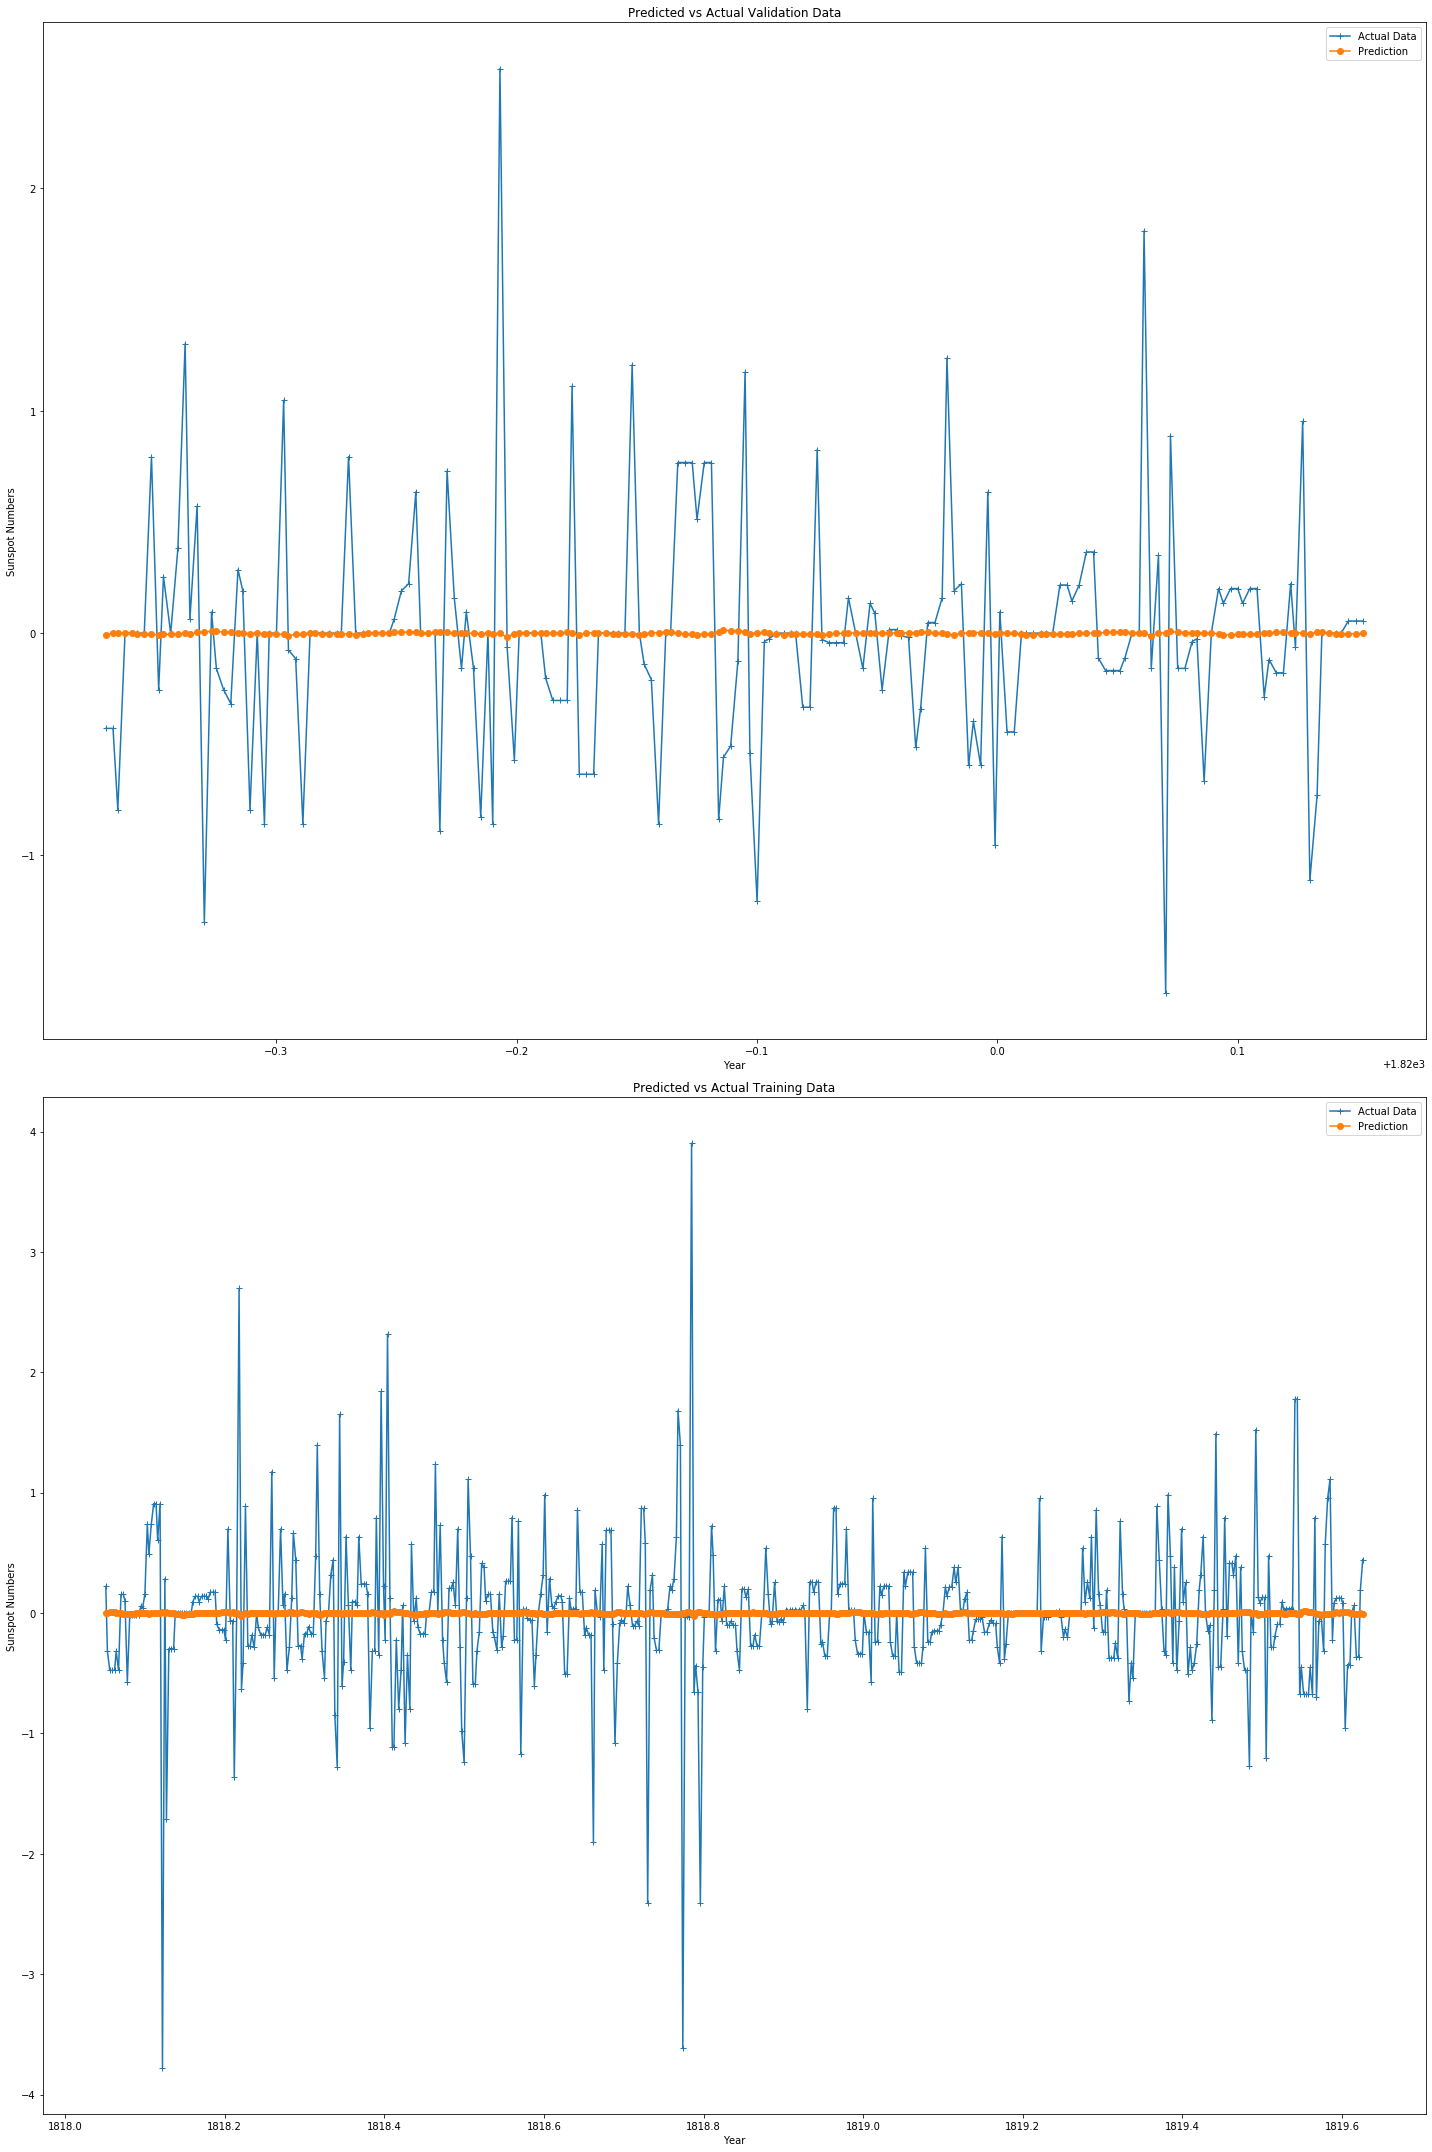

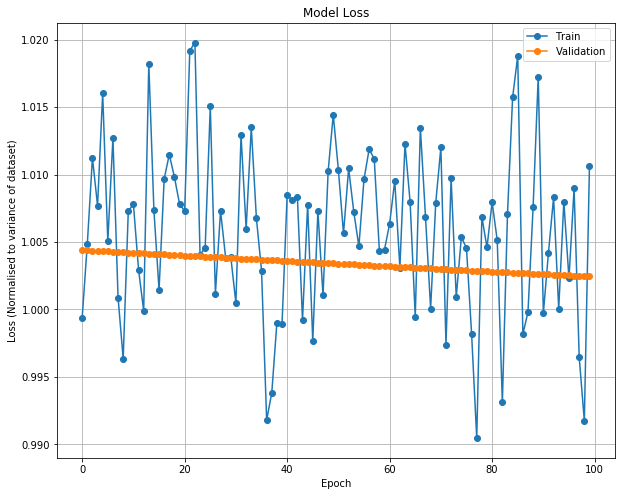

In [10]:
plotter.plot_predictions(net, x_train, y_train, idx_train, x_val, y_val, idx_val)
plotter.plot_loss_vs_epoch(history, var_train, var_val)

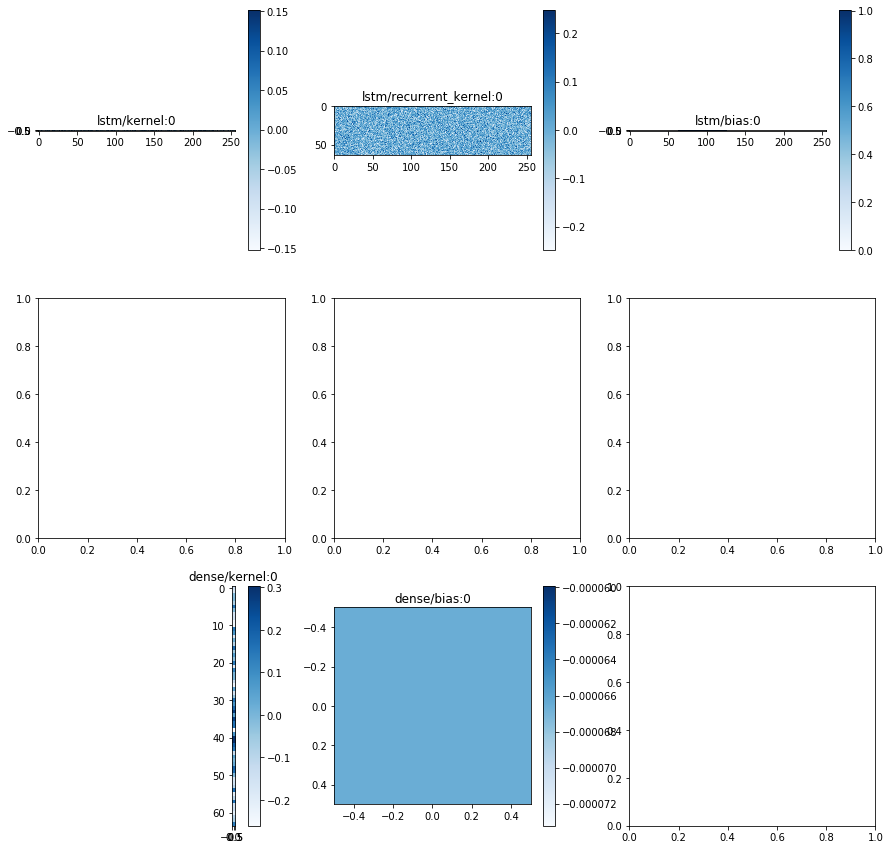

In [11]:
plotter.plot_weights(net)

In [19]:
%autoreload

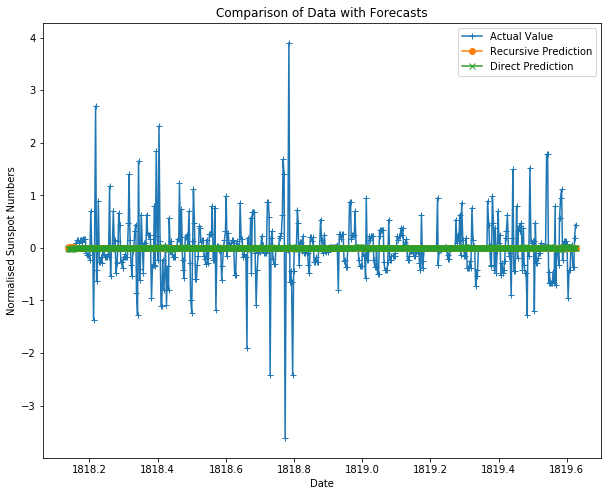

In [20]:
predictor = network.create_network(predictor=True)
predictor.set_weights(net.get_weights())

args = (
    predictor,
    x_train,
    y_train,
    idx_train
)
predictor.reset_states()
plotter.plot_recursive_predictions(*args)

In [ ]:
%tensorboard --logdir logs/fit